In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler

In [9]:
df_quake = pd.read_csv('data/quake.csv')
df_quake.columns = ['lat', 'long']
df_quake.head()

,lat,long
0,45.53,150.93
1,41.85,142.78
2,29.19,141.15
3,-21.66,169.81
4,23.09,120.58


A função a seguir repete a execução do KMeans $n$ vezes e retorna o modelo com o melhor erro de reconstrução, o qual pode ser calculado por:
$$
\mathcal{J}(\mathcal{C}) = \sum_{k = 1}^K \sum_{\boldsymbol{x}_i \in C_k} ||\boldsymbol{x}_i - \boldsymbol{m}_k||^2,
$$
Onde:
- $\boldsymbol{m}_k$ são os centróides do k-ésimo cluster;
- e $C_k$ são as partições.

OBS: o Scikit trata ele como inércia.

In [10]:
def run_kmeans_best_of_n(X, k, n_repeats=20, max_iter=300, random_state=0):
    best_model = None
    best_inertia = np.inf

    for r in range(n_repeats):
        km = KMeans(
            n_clusters=k,
            init='k-means++',
            n_init=1,              # controlamos a repetição fora do loop
            max_iter=max_iter,
            random_state=random_state + r,
            algorithm='lloyd'      # utiliza o algoritmo de Lloyd (padrão)
        )
        km.fit(X)

        if km.inertia_ < best_inertia:
            best_inertia = km.inertia_
            best_model = km

    return best_model, best_inertia

O índice Davies-Bouldin (DB) é computado como:
$$
\text{DB}(\mathcal{C}) = \frac{1}{K} \sum_{k = 1}^K \max_{k' \neq k} \left( \frac{\delta_k + \delta_{k'}}{\Delta_{kk'}} \right),
$$
Onde:
- $\delta_k$ é o espalhamento intra-agrupamento;
- e $\Delta_k$ é o  espalhamento entre grupos.

Além disso,
$$
\delta_k = \frac{1}{N_k} \sum_{\boldsymbol{x} \in C_k} ||\boldsymbol{x}_n - \boldsymbol{m}_k||,
$$
$$
\Delta_{kk'} = ||\boldsymbol{m}_k - \boldsymbol{m}_{k'}||,
$$
$$
\boldsymbol{m}_k = \frac{1}{N_k} \sum_{\boldsymbol{x} \in C_k} \boldsymbol{x}_i.
$$

In [11]:
def davies_bouldin_custom(X, labels, metric='euclidean', inv=None):
    X = np.asarray(X, float)
    labels = np.asarray(labels)
    clusters = np.unique(labels)
    k = len(clusters)
    if k < 2:
        raise ValueError('DB precisa de, pelo menos, 2 clusters.')

    # Cria um vetor coluna calculando os valores dos centróides de cada cluster
    # a partir da média dos valores
    centroids = np.vstack([X[labels == c].mean(axis=0) for c in clusters])

    def dist(a, b):
        d = a - b
        if metric == 'euclidean':
            return np.sqrt(np.dot(d, d))
        elif metric == 'mahalanobis':
            if inv is None:
                raise ValueError('Para Mahalanobis, forneça a matriz de covariância inversa')
            return np.sqrt(d @ inv @ d)
        else:
            raise ValueError('Métrica inválida')

    # delta_k: média das distâncias dos pontos ao centróide do cluster k
    deltas = np.zeros(k)
    for i, c in enumerate(clusters):
        Xi = X[labels == c]
        if Xi.shape[0] == 0:
            raise ValueError('Cluster vazio.')
        deltas[i] = np.mean([dist(x, centroids[i]) for x in Xi])

    # D: distâncias entre centróides
    D = np.zeros((k, k))
    for i in range(k):
        for j in range(i + 1, k):
            D[i, j] = D[j, i] = dist(centroids[i], centroids[j])

    Rmax = np.zeros(k)
    for i in range(k):
        ratios = []
        for j in range(k):
            if i == j:
                continue
            if D[i, j] == 0:
                ratios.append(np.inf)
            else:
                ratios.append((deltas[i] + deltas[j]) / D[i, j])
        Rmax[i] = np.max(ratios)

    return np.mean(Rmax)

In [12]:
def plot_clusters(X, labels, centroids, title, xlabel="long", ylabel="lat"):
    plt.figure(figsize=(7, 6))
    plt.scatter(X[:, 1], X[:, 0], c=labels, s=18, alpha=0.75)
    plt.scatter(centroids[:, 1], centroids[:, 0], c="black", s=120, marker="X")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.25)
    plt.show()

### Distância euclidiana

=== (a) Euclidiano: resultados por k ===
     k  db_euclid     inertia
16  20   0.568953   76.636717
11  15   0.584838  112.538964
8   12   0.590383  157.041616
6   10   0.591239  211.364562
15  19   0.592025   81.612871
10  14   0.592255  123.045726
14  18   0.593779   89.005595
9   13   0.596555  139.471822
12  16   0.596637  104.380149
13  17   0.600595   96.020603

Melhor k (Euclidiano) = 20 | DB = 0.568953 | inertia = 76.636717


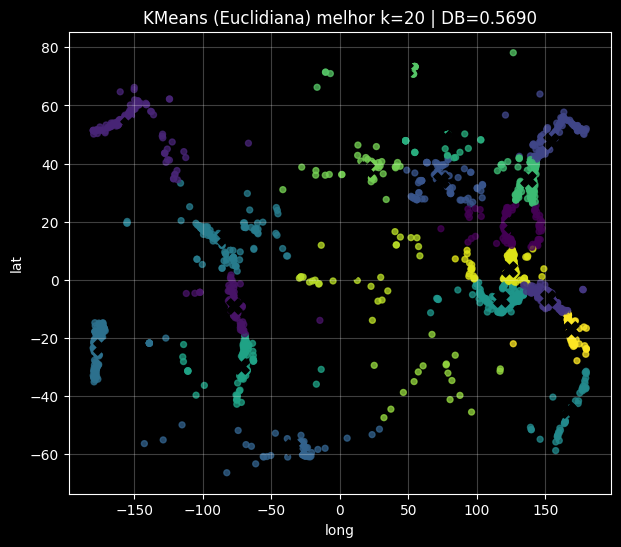

In [13]:
X_raw = df_quake[['lat', 'long']].to_numpy(dtype=float)
X = X_raw.copy()

scaler_euc = StandardScaler()
X = scaler_euc.fit_transform(X)

k_values = list(range(4, 21))
n_repeats = 20

results_euc = []
best_overall_euc = None  # (db, k, model, inercia)

for k in k_values:
    model, inertia = run_kmeans_best_of_n(X, k, n_repeats=n_repeats, random_state=12345)
    labels = model.labels_
    db = davies_bouldin_score(X, labels)  # DB com distancia euclidiana
    results_euc.append((k, db, inertia))

    if best_overall_euc is None or db < best_overall_euc[0]:
        best_overall_euc = (db, k, model, inertia)

results_euc = pd.DataFrame(results_euc, columns=["k", "db_euclid", "inertia"])
print("=== (a) Euclidiano: resultados por k ===")
print(results_euc.sort_values("db_euclid").head(10))

best_db, best_k, best_model, best_inertia = best_overall_euc
print(f"\nMelhor k (Euclidiano) = {best_k} | DB = {best_db:.6f} | inertia = {best_inertia:.6f}")

# Plot do melhor agrupamento (em escala original)
labels_best = best_model.labels_
centroids_best = scaler_euc.inverse_transform(best_model.cluster_centers_)
plot_clusters(
    X_raw,
    labels_best,
    centroids_best,
    title=f"KMeans (Euclidiana) melhor k={best_k} | DB={best_db:.4f}",
    xlabel="long", ylabel="lat"
)

### Distância de Mahalanobis

=== (b) Mahalanobis: resultados por k ===
     k  db_mahalanobis     inertia
16  20        0.562217   76.636717
8   12        0.571137  157.041616
10  14        0.576686  123.045726
9   13        0.579383  139.471822
6   10        0.582625  211.364562
11  15        0.584712  112.538964
15  19        0.589542   81.612871
13  17        0.598004   96.020603
14  18        0.599700   89.005595
7   11        0.604720  181.393019

Melhor k (Mahalanobis) = 20 | DB = 0.562217 | inertia = 76.636717


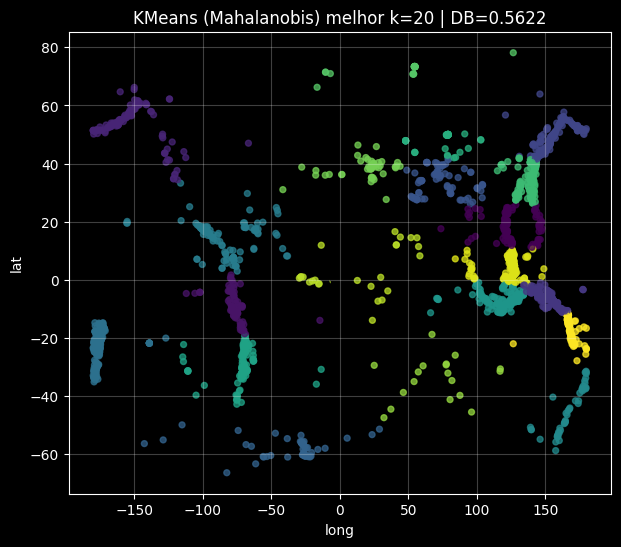

In [15]:
Sigma = np.cov(X_raw, rowvar=False)
inv = np.linalg.inv(Sigma)

results_mh = []
best_overall_mh = None  # (db, k, model, inercia)

for k in k_values:
    model, inertia = run_kmeans_best_of_n(X, k, n_repeats=n_repeats, random_state=12345)
    labels = model.labels_
    db = davies_bouldin_custom(X_raw, labels, metric='mahalanobis', inv=inv)
    results_mh.append((k, db, inertia))

    if best_overall_mh is None or db < best_overall_mh[0]:
        best_overall_mh = (db, k, model, inertia)

results_mh = pd.DataFrame(results_mh, columns=["k", "db_mahalanobis", "inertia"])
print("=== (b) Mahalanobis: resultados por k ===")
print(results_mh.sort_values("db_mahalanobis").head(10))

best_db, best_k, best_model, best_inertia = best_overall_mh
print(f"\nMelhor k (Mahalanobis) = {best_k} | DB = {best_db:.6f} | inertia = {best_inertia:.6f}")

plot_clusters(
    X_raw,
    best_model.labels_,
    best_model.cluster_centers_,
    title=f"KMeans (Mahalanobis) melhor k={best_k} | DB={best_db:.4f}",
    xlabel="long", ylabel="lat"
)